<a href="https://colab.research.google.com/github/Shreyo2/AD-CTR-ANALYSIS-AND-FORECASTING/blob/main/Ad_ctr_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import cufflinks as cf

data = pd.read_csv("/content/ctr.csv")
print(data.head())

         date  Clicks  Impressions
0  19-10-2022    2851        58598
1  20-10-2022    2707        57628
2  21-10-2022    2246        50135
3  22-10-2022    1686        40608
4  23-10-2022    1808        41999


In [5]:
# Data Preparation
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
data.set_index('date', inplace=True)

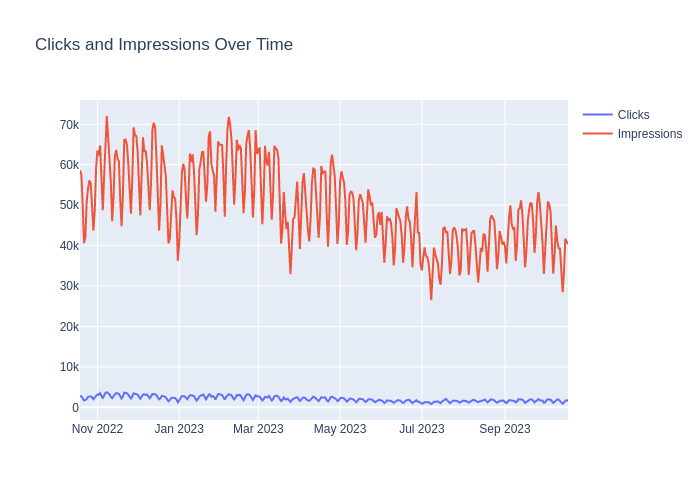

In [14]:
# Visualize Clicks and Impressions
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Clicks'], mode='lines', name='Clicks'))
fig.add_trace(go.Scatter(x=data.index, y=data['Impressions'], mode='lines', name='Impressions'))
fig.update_layout(title='Clicks and Impressions Over Time')
fig.show("png")

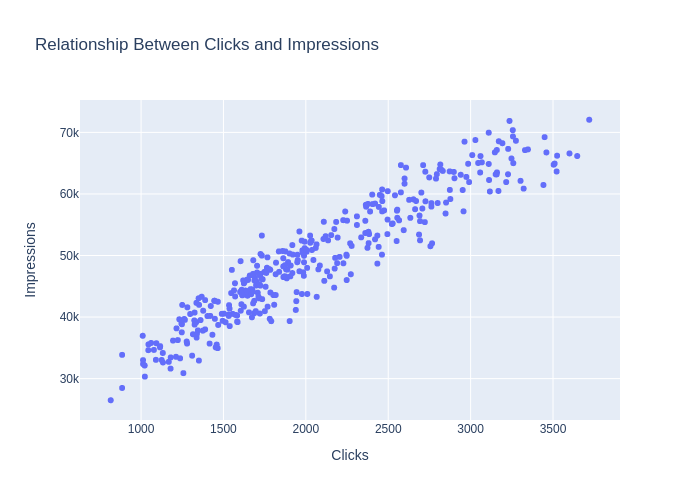

In [9]:
# Create a scatter plot to visualize the relationship between Clicks and Impressions
fig = px.scatter(data, x='Clicks', y='Impressions', title='Relationship Between Clicks and Impressions',
                 labels={'Clicks': 'Clicks', 'Impressions': 'Impressions'})

# Customize the layout
fig.update_layout(xaxis_title='Clicks', yaxis_title='Impressions')

# Show the plot
fig.show("png")

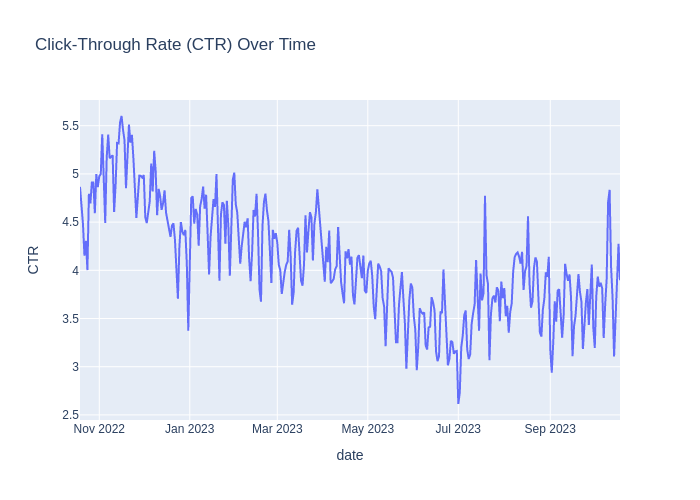

In [10]:
# Calculate and visualize CTR
data['CTR'] = (data['Clicks'] / data['Impressions']) * 100
fig = px.line(data, x=data.index, y='CTR', title='Click-Through Rate (CTR) Over Time')
fig.show("png")

In [ ]:
data['DayOfWeek'] = data.index.dayofweek

# EDA based on DayOfWeek
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = px.bar(day_of_week_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show()

In [ ]:
data.dtypes

Clicks           int64
Impressions      int64
CTR            float64
DayOfWeek        int32
dtype: object

In [ ]:
# Create a new column 'DayCategory' to categorize weekdays and weekends
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

# Create a bar plot to compare CTR on weekdays vs. weekends
fig = px.bar(ctr_by_day_category, x='DayCategory', y='CTR', title='Comparison of CTR on Weekdays vs. Weekends',
             labels={'CTR': 'Average CTR'})

# Customize the layout
fig.update_layout(yaxis_title='Average CTR')

# Show the plot
#fig.show()

In [ ]:
# Group the data by 'DayCategory' and calculate the sum of Clicks and Impressions for each category
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
fig = px.bar(grouped_data, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

# Customize the layout
fig.update_layout(yaxis_title='Count')
fig.update_xaxes(title_text='Day Category')

# Show the plot
fig.show()

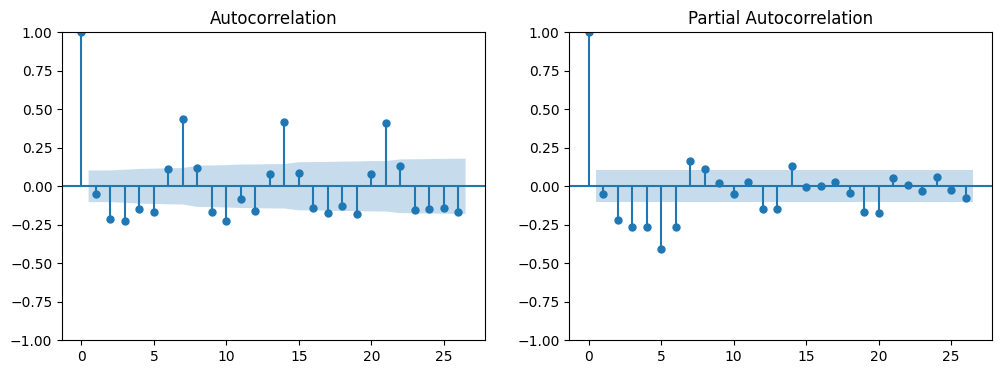

In [ ]:
data.reset_index(inplace=True)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# resetting index
time_series = data.set_index('date')['CTR']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Tue, 25 Jun 2024   AIC                            152.730
Time:                                    07:52:00   BIC                            172.048
Sample:                                10-19-2022   HQIC                           160.418
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5266      0.070      7.513      0.000       0.389       0.664
ma.L1         -0.9049      0.036   

In [ ]:
# Predict future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    3.852350
2023-10-20    3.889426
2023-10-21    3.820260
2023-10-22    3.727494
2023-10-23    3.710360
                ...   
2024-01-22    3.545574
2024-01-23    3.466648
2024-01-24    3.561193
2024-01-25    3.546697
2024-01-26    3.580132
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


In [ ]:
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='CTR Forecasting',
                  xaxis_title='Time Period',
                  yaxis_title='Impressions',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()